In [5]:
import os
notebook_wd = os.getcwd()

In [6]:
import pandas as pd
import numpy as np

os.chdir(os.path.join(notebook_wd, '..'))
from src.d00_utils.conf_utils import *

In [7]:
compounds, water = load_compounds()
experiments = load_experiments()
constants = load_constants()
paths = load_paths()
experiments['bd_dry']

{'composition': {'Butenedial': 0.075, 'PEG-6': 0.2},
 'solution_name': 'bd10hg20_008',
 'idx_range': [63, 500],
 'bad_idx': [113],
 'trap_time': [2, 50],
 'other_query': 'rh<20',
 'y_col': 'n85',
 'p283_cutoff': 1000,
 'columns_to_keep': ['trapped', 'comp', 'experiment', 'n85'],
 'number_of_steps': 3000.0,
 'r_init': [1.14e-05, 1.44e-05],
 'T': [298.6, 301.6],
 'RH': [0.0, 0.05],
 'x_water': [0.0, 0.05],
 'value_idx': 0,
 'norm_idx': 1,
 'cal_data_time': 5,
 'label': 'BD (dry)'}

In [8]:
from src.d00_utils.conf_utils import get_project_directory

def import_ms_data(file_name, directory=None):
    
    if directory is not None:
        data_path = os.path.join(directory, file_name)
    else:
        project_dir = get_project_directory()
        data_path = os.path.join(project_dir, 'data', file_name)
        
    df = pd.read_csv(data_path)
    
    return df

In [9]:
df = import_ms_data(file_name=paths['raw_data'])
df.head()

,date,file,chrom,dc_trap,mfc,src1,src2,signal,vialstart,trapstart,...,p84_j,p85_j,p283_j,n84_j,n84,n85_j,n85,bad_data,nh3_vial,naoh_vial
0,180815,6,0.52,680.0,303.0,NaN,NaN,1,NaN,NaN,...,NaN,3470.9,58881.1,NaN,0.000705,0.058948,0.058387,NaN,NaN,NaN
1,180815,6,8.66,600.0,244.0,NaN,NaN,1,NaN,NaN,...,NaN,1370.8,21289.4,NaN,0.001825,0.064389,0.060608,NaN,NaN,NaN
2,180816,1,0.85,470.0,250.0,NaN,NaN,1,NaN,NaN,...,NaN,1738.1,55019.3,NaN,0.000779,0.031591,0.032168,NaN,NaN,NaN
3,180816,2,1.00,570.0,275.0,NaN,NaN,1,NaN,NaN,...,NaN,2199.8,98592.0,NaN,0.000090,0.022312,0.022524,NaN,NaN,NaN
4,180816,3,1.00,560.0,245.0,NaN,NaN,1,NaN,NaN,...,NaN,477.2,20871.9,NaN,0.002030,0.022863,0.021951,NaN,NaN,NaN


In [10]:
def add_normalized_intensity_column(df, internal_std='p283'):
    """Add "n###" columns to DataFrame of normalized peak intensities.

    """

    p_cols = [col for col in df.columns if col[0] == 'p']  # first column of mass spec peaks is p

    for tick, p_col in enumerate(p_cols):
        df['n' + p_col[1:]] = df[p_col] / df[internal_std]

    return df

In [11]:
df = add_normalized_intensity_column(df)
df.comp.unique()

array(['bd10hg20_001', 'bd10hg20_002', 'hg20as10_002', 'bd10hg10sc10_001',
       'bd10hg10ss10_001', 'bd10hg20_005', 'bd10hg20_006', 'bd10hg20_007',
       'bd10hg20_008', 'bd10hg15ss05_001', 'bd15hg14sc02_001'],
      dtype=object)

In [12]:
def filter_ms_data_in_experiments(df, experiment_parameters):
    """
    """

    df_filtered = pd.DataFrame()
    for experiment_name, experiment in experiment_parameters.items():
        query_parts = []
        query_parts.append("comp == '{}'".format(experiment['solution_name']))
        query_parts.append("trapped>={} and trapped<{}".format(*experiment['trap_time']))

        if experiment['other_query'] is not None:
            query_parts.append(experiment['other_query'])

        query = " and ".join(query_parts)

        df_experiment = (df.query(query).loc[experiment['idx_range'][0]:experiment['idx_range'][1]])
        if experiment['bad_idx'] is not None:
            df_experiment = df_experiment.drop(experiment['bad_idx'])

        df_experiment['experiment'] = experiment_name
        df_filtered = df_filtered.append(df_experiment)

    return df_filtered

In [13]:
df_filtered = filter_ms_data_in_experiments(df, experiment_parameters=experiments)
df_filtered.experiment.unique()

array(['bd_dry', 'bd_wet', 'bd_nacl_high', 'bd_nacl_low',
       'bd_na2so4_high', 'bd_na2so4_low'], dtype=object)

In [14]:
def clean_ms_data_in_experiments(df_filtered, experiment_parameters):
    """
    """

    df_cleaned = pd.DataFrame()

    for name, experiment in experiment_parameters.items():
        experiment_cleaned = df_filtered[df_filtered.experiment == name][experiment['columns_to_keep']]

        df_cleaned = df_cleaned.append(experiment_cleaned)

    df_cleaned = df_cleaned.rename(columns={'trapped': 'mins', 'comp': 'solution_name'})

    return df_cleaned

In [15]:
df_cleaned = clean_ms_data_in_experiments(df_filtered, experiment_parameters=experiments)
df_cleaned.head()

,mins,solution_name,experiment,n85
102,23.0,bd10hg20_008,bd_dry,0.009295
103,22.0,bd10hg20_008,bd_dry,0.014990
104,21.0,bd10hg20_008,bd_dry,0.005597
105,46.0,bd10hg20_008,bd_dry,0.013988
107,10.0,bd10hg20_008,bd_dry,0.027411


In [16]:
df_cleaned.experiment.isin(['bd_hg_dry'])

102    False
103    False
104    False
105    False
107    False
108    False
109    False
114    False
115    False
116    False
117    False
118    False
119    False
120    False
121    False
122    False
123    False
138    False
139    False
18     False
19     False
20     False
21     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
       ...  
149    False
160    False
161    False
162    False
163    False
164    False
165    False
70     False
71     False
72     False
73     False
74     False
76     False
77     False
78     False
79     False
80     False
81     False
82     False
183    False
184    False
185    False
186    False
187    False
188    False
189    False
191    False
192    False
193    False
194    False
Name: experiment, Length: 90, dtype: bool

In [78]:
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt

def plot_ms_data(df, experiment_names, t_col_name, y_col_name, y_axis_label):
    """ plots time evolution of compounds in solution (e.g., droplet). Figure saved in results as png.

    :param compounds: (dict) dictionary of definitions of each compound.
    :param ts: (ndarray(floats)) 1D array of floats of times in simulation.
    :param ys: (ndarray(floats)) 2D array of floats of y parameter to plot by compound and time in simulation.
    :param y_axis: (str) can either be M, n, or N and governs the resulting y axis label. corresponds to ys.
    :param rs: (ndarray(floats)) 1D array of floats of radii (m) in time in simulation. Not plotted if None.
    """

    sns.set(style="ticks")  # sets sns as the rule
    sns.set_context("talk")
    sns.set_palette("Spectral")

    N_expt = len(experiment_names)
    x_max = 0
    y_max = 0
    for tick in range(N_expt):
        experiment_name = experiment_names[tick]
        xs = df[df.experiment == experiment_name][t_col_name]
        ys = df[df.experiment == experiment_name][y_col_name]
        
        if xs.max() > x_max:
            x_max = xs.max()
        if ys.max() > y_max:
            y_max = ys.max()
        
        ax = sns.scatterplot(x=xs, y=ys, label=experiment_name, alpha=1, s=200)

    ax.set(xlabel='time (%s)' % (t_col_name), ylabel=y_axis_label, 
           ylim=(-y_max*0.1, y_max*1.1), xlim=(-x_max*0.05, x_max*1.05))
    ax.legend(title='Experiment')

    project_dir = get_project_directory()
    today_str = date.today().strftime("%Y%m%d")
    expt_strings = '-'.join(experiment_names)
    file_name = today_str[2:] + '-' + expt_strings + '.png'
    file_path = os.path.join(project_dir, 'results', 'figs_out', file_name)

    plt.savefig(file_path, bbox_inches='tight', dpi=300, transparent=True)

In [76]:
df_cleaned.experiment.unique()

array(['bd_dry', 'bd_wet', 'bd_nacl_high', 'bd_nacl_low',
       'bd_na2so4_high', 'bd_na2so4_low'], dtype=object)

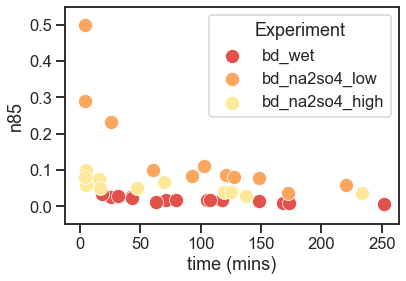

In [79]:
plot_ms_data(df_cleaned, ['bd_wet', 'bd_na2so4_low', 'bd_na2so4_high'], 'mins', 'n85', y_axis_label='n85')